In [ ]:
!pip install torchview
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import torch
import PIL.Image
import os
import seaborn as sbn
from albumentations import GaussNoise, RandomGridShuffle, Normalize, PixelDropout
from scipy.ndimage import gaussian_filter, map_coordinates

from torchview import draw_graph
import graphviz
import tensorflow as tf
import visualkeras

graphviz.set_jupyter_format('png')

sbn.set()

from google.colab import drive
drive.mount('/content/drive')

datadir = "/content/drive/MyDrive/Colab Notebooks/datasets/aia/EM_ISBI_Challenge/"

Mounted at /content/drive


## Load data into sets

In [ ]:
class ChallengeData(torch.utils.data.Dataset):
    '''  Dataset which loads all images for training or testing'''
    def __init__(self, data_dir, nr_im, train_set, new_size, margin_size=20):
        self.images = []
        self.labels = []

        self.train_set = train_set
        self.new_size = new_size
  
        normalizer = Normalize(mean=(0.5), std=(0.5))

        img_prefix = 'train' if train_set else 'test'
        img_folder = 'train_images' if train_set else 'test_images'
        labels_folder = 'train_labels'
        labels_prefix = 'labels'

        for idx in range(1, nr_im + 1):
            im = np.array(PIL.Image.open(f'{data_dir}/{img_folder}/{img_prefix}_{idx:02d}.png'))
            # im = im/255
            im = normalizer.apply(image=im, p=1)
            
            # Divide into images of size new_size x new_size
            height, width = im.shape[:2]
            for i in range(0, height, new_size):
                for j in range(0, width, new_size):
                    self.images.append(torch.tensor(im[i:i+new_size, j:j+new_size], dtype=torch.float32))
            
            if train_set:
                label_im = np.array(PIL.Image.open(f'{data_dir}/{labels_folder}/{labels_prefix}_{idx:02d}.png'))
                label_im = label_im/255
                # label_im = label_im[margin_size:-margin_size, margin_size:-margin_size]/255
                
                # Divide into images of size new_size x new_size
                height, width = label_im.shape[:2]
                for i in range(0, height, new_size):
                    for j in range(0, width, new_size):
                        self.labels.append(torch.tensor(label_im[i:i+new_size, j:j+new_size], dtype=torch.int64))

    def __getitem__(self, idx):
        if self.train_set:
            return self.images[idx], self.labels[idx]
        
        return self.images[idx]
    
    def __len__(self):
        return len(self.images)

In [ ]:
# Make training and validation set.
# (This involves loading images and may take some seconds.)

new_size = 256 # With 256 the 512x512 images will be divided into 4 256x256 images

challengeTrainData = ChallengeData(datadir, 30, True, new_size=new_size)
challengeTestData = ChallengeData(datadir, 30, False, new_size=new_size)


In [ ]:
trainloader = torch.utils.data.DataLoader(challengeTrainData,
                                          batch_size=10,
                                          shuffle=True,
                                          drop_last=True)
testloader = torch.utils.data.DataLoader(challengeTestData,
                                          batch_size=20)

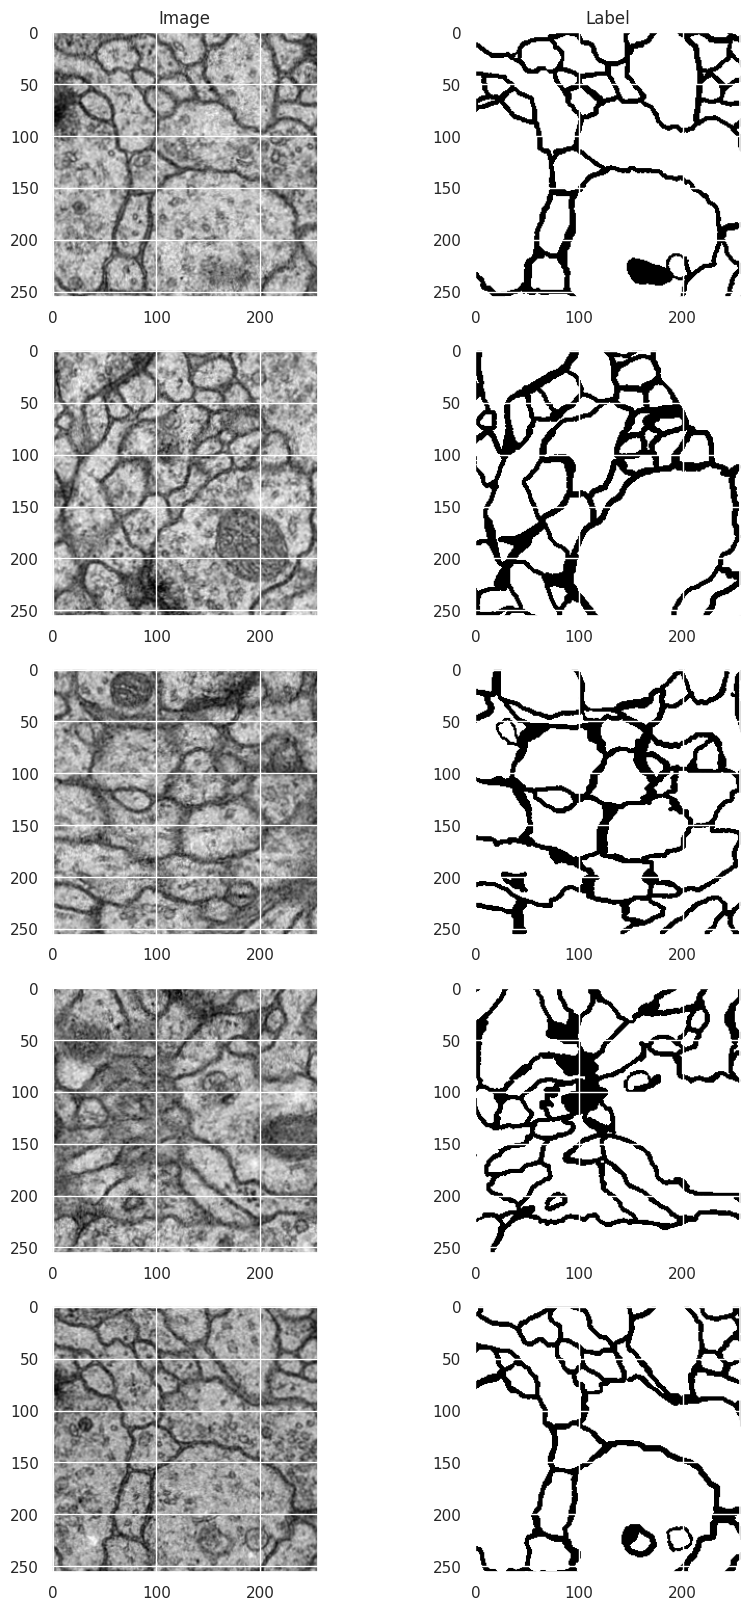

In [ ]:
# Plot the first 5 images and labels in the train set
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    ax[i, 0].imshow(challengeTrainData[i][0], cmap='gray')
    ax[i, 1].imshow(challengeTrainData[i][1], cmap='gray')

ax[0, 0].set_title('Image')
ax[0, 1].set_title('Label');

## Dice Loss (to use it uncomment "loss_function = dice_loss" before the training)

In [ ]:
# Test 
def dice_loss(y_pred, y_true, smooth=1):
    """
    Computes the Dice loss between the predicted output and the true target.

    Args:
        y_pred (torch.Tensor): predicted output of shape (N, C, H, W)
        y_true (torch.Tensor): true target of shape (N, H, W)
        smooth (float, optional): smoothing factor to avoid division by zero. Default: 1.

    Returns:
        torch.Tensor: Dice loss
    """
    num_classes = y_pred.size(1)
    y_true = y_true.unsqueeze(1)  # (N, 1, H, W)
    y_true = torch.zeros_like(y_pred).scatter_(1, y_true, 1)  # (N, C, H, W)
    intersection = y_pred * y_true
    numerator = 2 * intersection.sum(dim=(2, 3)) + smooth
    denominator = y_pred.sum(dim=(2, 3)) + y_true.sum(dim=(2, 3)) + smooth
    loss_per_class = 1 - numerator / denominator
    return loss_per_class.mean()

## U-net

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/zhanghang1989/PyTorch-Encoding/blob/master/encoding/models/seg_hrnet.py
        # x = torch.cat([x2, x1], dim=1)
        return self.conv(torch.cat([x2, x1], dim=1))


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2= Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

### Train U-net

In [ ]:
%%time

loss_function = torch.nn.CrossEntropyLoss()
net = UNet(n_channels=1, n_classes=2, bilinear=True)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
epochs = 5

epoch_train_losses = []

# Train the network
for e in range(epochs):
    train_losses = []
    for batch in trainloader:
        optimizer.zero_grad()
        output = net(batch[0].unsqueeze(1))
        loss = loss_function(output, batch[1])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    epoch_train_losses.append(np.mean(train_losses))

    print(f'Epoch {e+1}/{epochs} | Train loss: {epoch_train_losses[-1]:.6f}')

Epoch 1/5 | Train loss: 0.468936
Epoch 2/5 | Train loss: 0.297903
Epoch 3/5 | Train loss: 0.259751
Epoch 4/5 | Train loss: 0.237255
Epoch 5/5 | Train loss: 0.227282
CPU times: user 42min 48s, sys: 4min 43s, total: 47min 31s
Wall time: 47min 37s


### Save model

In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/datasets/aia/EM_ISBI_Challenge/models/unet2_weights.pth')


### Load model

In [ ]:
net = UNet(n_channels=1, n_classes=2, bilinear=True)
net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/datasets/aia/EM_ISBI_Challenge/models/unet_weights.pth'))

<All keys matched successfully>

### Visualize model

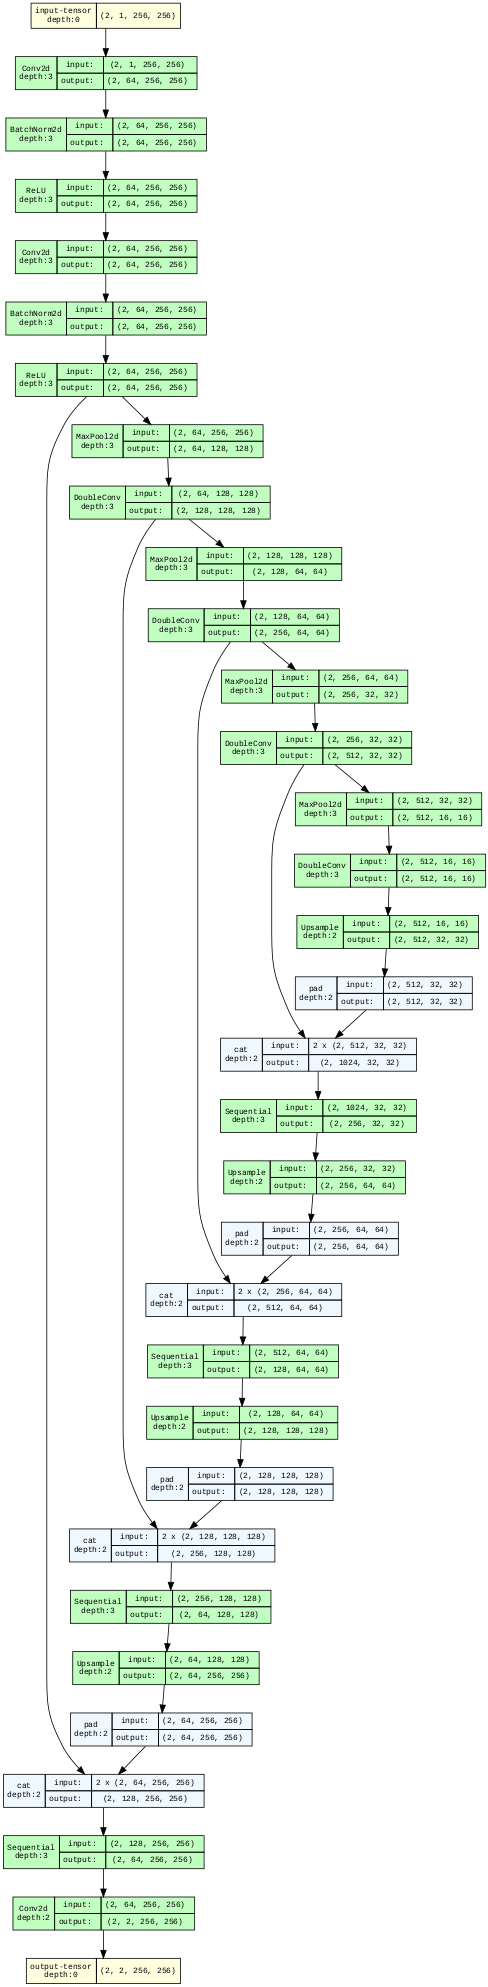

In [ ]:
batch_size = 2
model_graph = draw_graph(net, input_size=(batch_size, 1, 256, 256), device='meta')
model_graph.visual_graph


## Improved model

In [ ]:
# Original net (deleted):
# Create convolutional network taking size 256x256 as input and outputting size 256x256.
# The network should have 3 convolutional layers with 3x3 kernels and 1x1 stride.
# The first two layers should have 16 output channels, the last one should have 2 output channels.
# The first two layers should have ReLU activation, the last one should have no activation.
# The network should have a final softmax layer.

# Improved net:
# Added batch normalization after each convolutional layer to stabilize the training and improve the performance of the network.
# Added more convolutional layers to make the network deeper and potentially more accurate. (depth of the network: 4 convolutional layers)
# Increased the size of the convolutional kernels to capture more information from the input images. (used larger 5x5 and 3x3 kernels).
# Instead of using 1x1 stride, used strided convolutions to reduce the spatial size of the feature maps and make the network more computationally efficient. (strided convolutions with a stride of 2 in the first two layers to reduce the spatial size of the feature maps).
# Added a dropout layer after the third convolutional layer to reduce overfitting.

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 5, stride=2, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.conv4 = torch.nn.Conv2d(64, 2, 3, stride=1, padding=1)
        self.dropout = torch.nn.Dropout2d(p=0.5)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.conv4(x)
        # Resize the output to match the target size
        x = torch.nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)
        return torch.nn.functional.softmax(x, dim=1)

In [ ]:
epochs = 20
loss_function = torch.nn.CrossEntropyLoss()
# loss_function = dice_loss
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

epoch_train_losses = []

AttributeError: ignored

In [ ]:
# Train the network
for e in range(epochs):
    train_losses = []
    for batch in trainloader:
        optimizer.zero_grad()
        output = net(batch[0].unsqueeze(1))
        loss = loss_function(output, batch[1])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    epoch_train_losses.append(np.mean(train_losses))

    print(f'Epoch {e+1}/{epochs} | Train loss: {epoch_train_losses[-1]:.6f}')

Epoch 1/20 | Train loss: 0.526378
Epoch 2/20 | Train loss: 0.463938
Epoch 3/20 | Train loss: 0.450808
Epoch 4/20 | Train loss: 0.444525
Epoch 5/20 | Train loss: 0.440346
Epoch 6/20 | Train loss: 0.437665
Epoch 7/20 | Train loss: 0.435846
Epoch 8/20 | Train loss: 0.433373
Epoch 9/20 | Train loss: 0.432835
Epoch 10/20 | Train loss: 0.431336
Epoch 11/20 | Train loss: 0.433791
Epoch 12/20 | Train loss: 0.431102
Epoch 13/20 | Train loss: 0.430513
Epoch 14/20 | Train loss: 0.427272
Epoch 15/20 | Train loss: 0.427709
Epoch 16/20 | Train loss: 0.425496
Epoch 17/20 | Train loss: 0.425249
Epoch 18/20 | Train loss: 0.423227
Epoch 19/20 | Train loss: 0.424500
Epoch 20/20 | Train loss: 0.424587


### Save model

In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/datasets/aia/EM_ISBI_Challenge/models/improved_net_weights2.pth')


### Load model

In [ ]:
net = Net()
net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/datasets/aia/EM_ISBI_Challenge/models/improved_net_weights.pth'))

### Visualize model (layers)

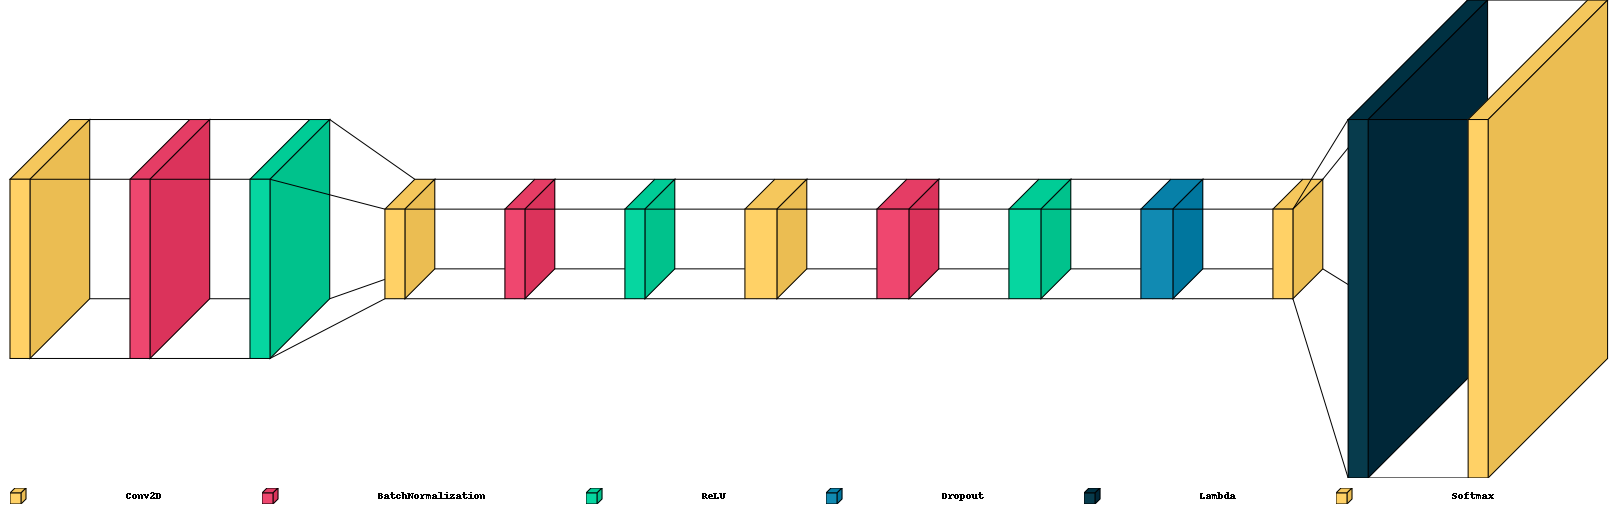

In [ ]:
# Redefine the torch model as a tensorflow one
input_shape = (512, 512, 1)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(16, 5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, 5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(2, 3, strides=1, padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=(512, 512), method=tf.image.ResizeMethod.BILINEAR)),
    tf.keras.layers.Softmax()
])

# create visualkeras graph with smaller layer size
visualkeras.layered_view(model, legend=True, spacing=100, scale_xy=0.7, scale_z=0.5)

### 2D representation

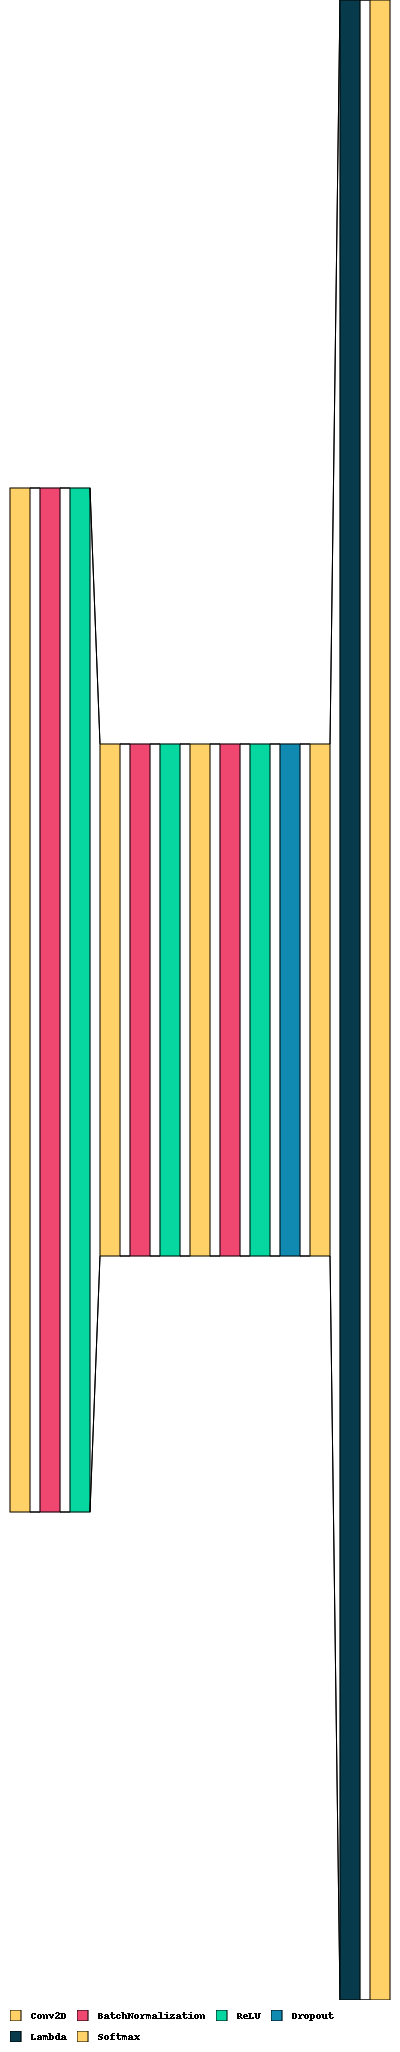

In [ ]:
visualkeras.layered_view(model, legend=True, draw_volume=False)

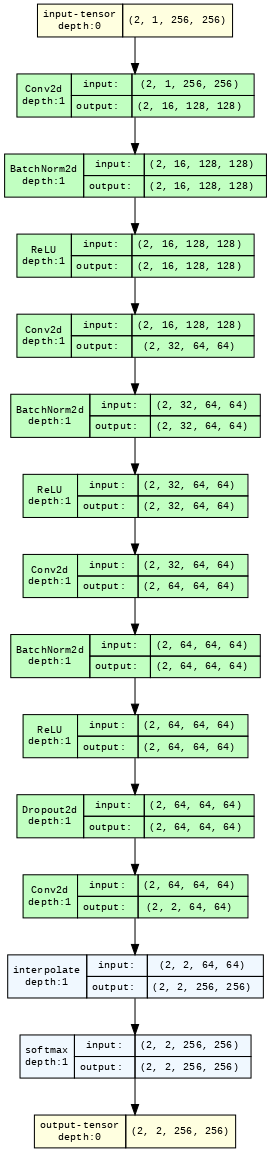

In [ ]:
batch_size = 2
model_graph = draw_graph(net, input_size=(batch_size, 1, 256, 256), device='meta')
model_graph.visual_graph

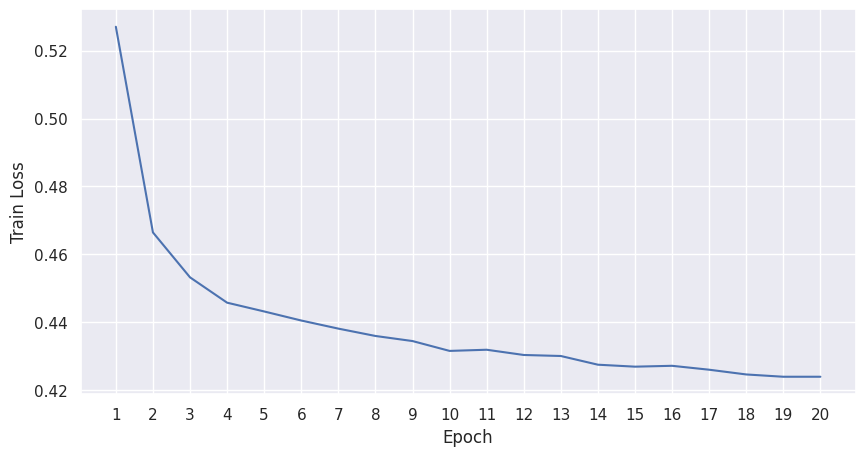

In [ ]:
# Plot the train loss
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(np.arange(1, epochs + 1, 1), epoch_train_losses)
ax.set_xlabel('Epoch')
ax.set_xticks(np.arange(1, epochs + 1, 1))
ax.set_ylabel('Train Loss')
plt.show()

CPU times: user 479 ms, sys: 954 µs, total: 480 ms
Wall time: 490 ms


Text(0.5, 1.0, 'Prediction')

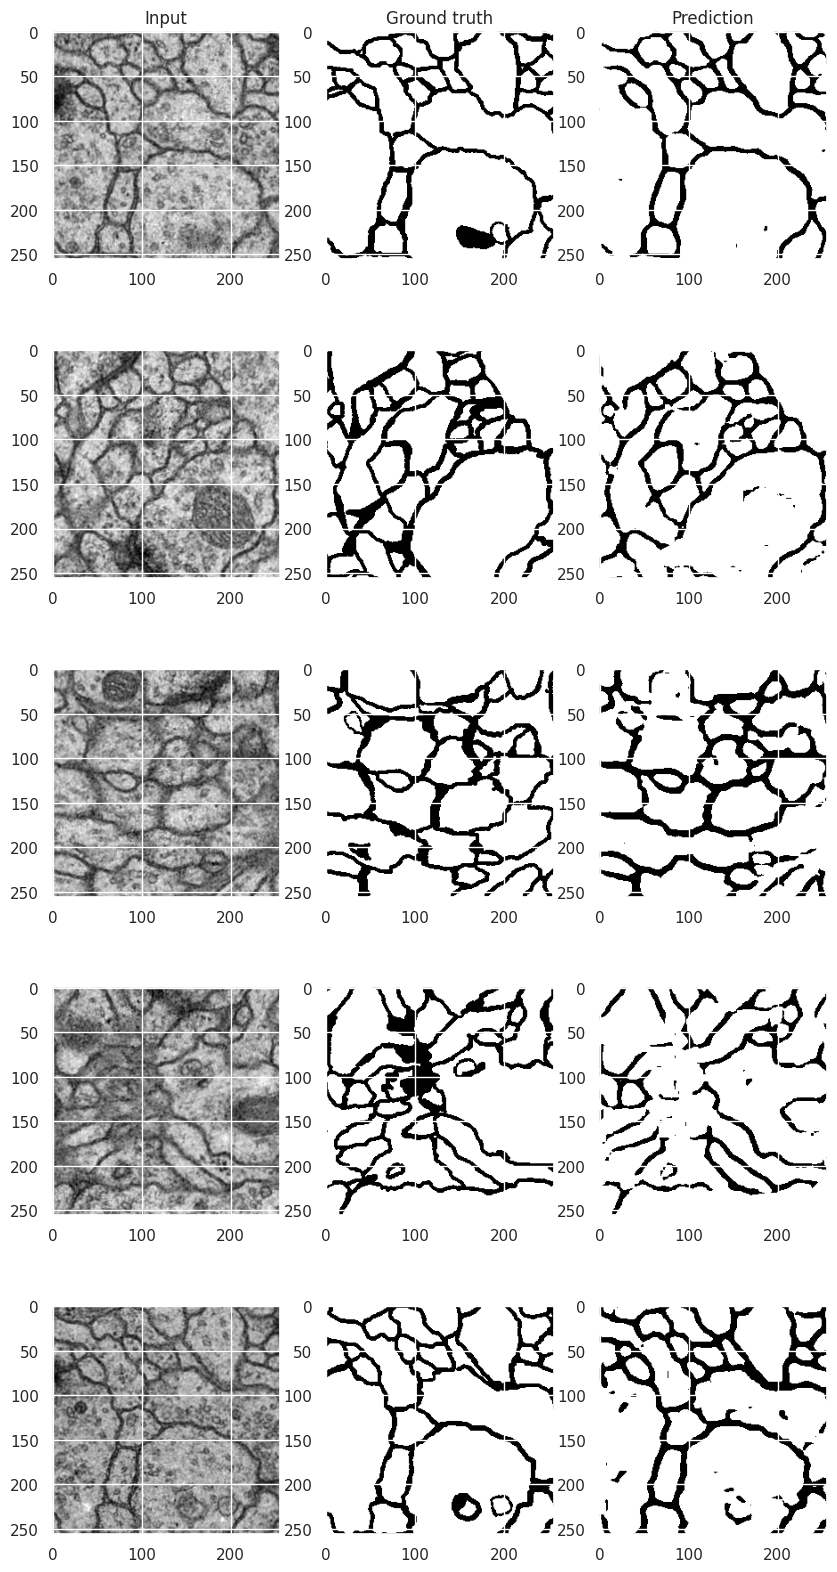

In [ ]:
%%time
# Visualize train predictions
fig, ax = plt.subplots(5, 3, figsize=(10, 20))
for i in range(5):
    ax[i, 0].imshow(challengeTrainData[i][0], cmap='gray')
    ax[i, 1].imshow(challengeTrainData[i][1], cmap='gray')
    ax[i, 2].imshow(torch.argmax(net(challengeTrainData[i][0].unsqueeze(0).unsqueeze(0)), dim=1)[0], cmap='gray')

ax[0, 0].set_title('Input')
ax[0, 1].set_title('Ground truth')
ax[0, 2].set_title('Prediction');

CPU times: user 6.56 s, sys: 13.2 ms, total: 6.58 s
Wall time: 6.56 s


Text(0.5, 1.0, 'Prediction')

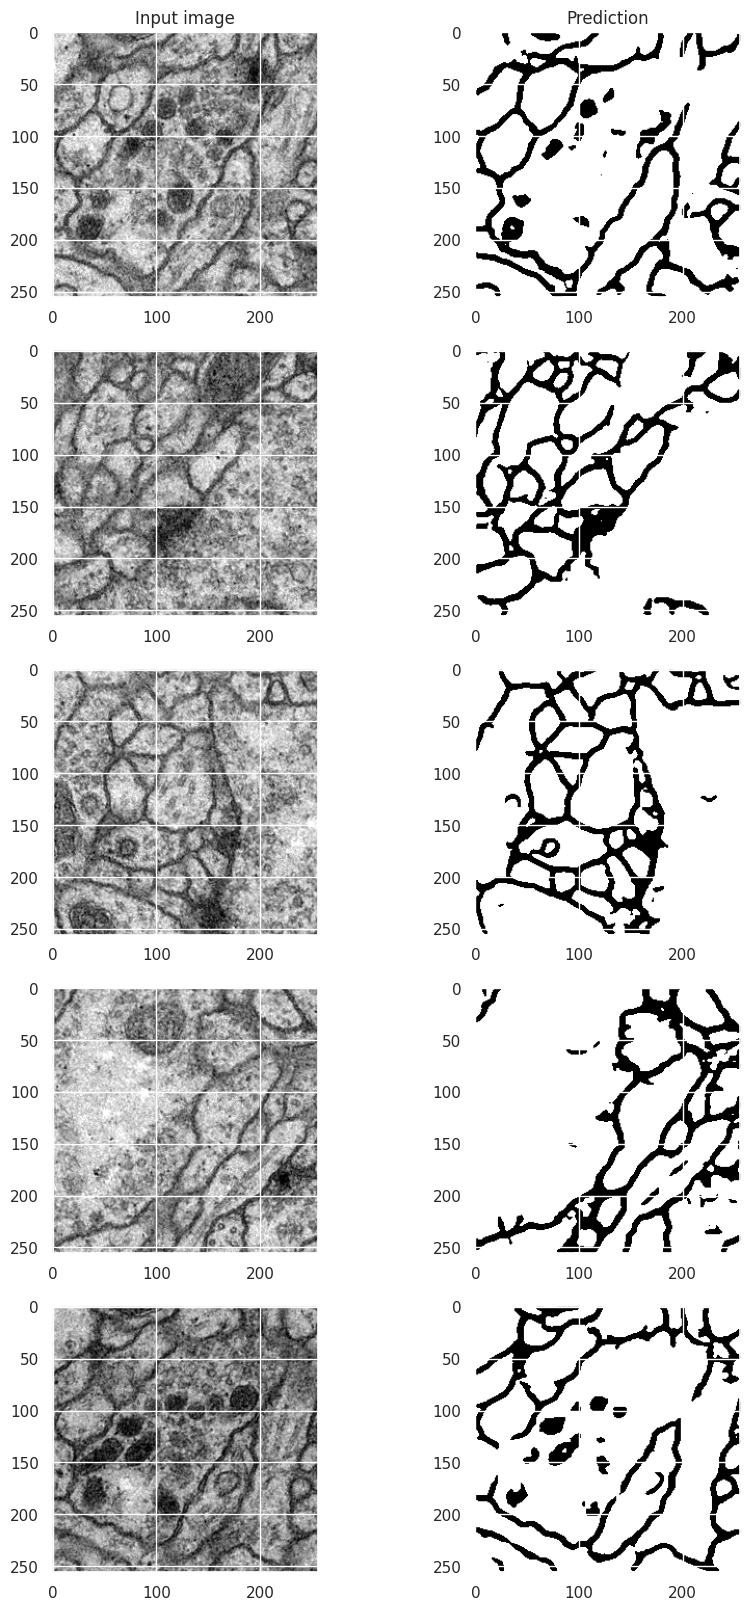

In [ ]:
%%time
# Visualize test predictions
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    ax[i, 0].imshow(challengeTestData[i], cmap='gray')
    ax[i, 1].imshow(torch.argmax(net(challengeTestData[i].unsqueeze(0).unsqueeze(0)), dim=1)[0], cmap='gray')

ax[0, 0].set_title('Input image')
ax[0, 1].set_title('Prediction');

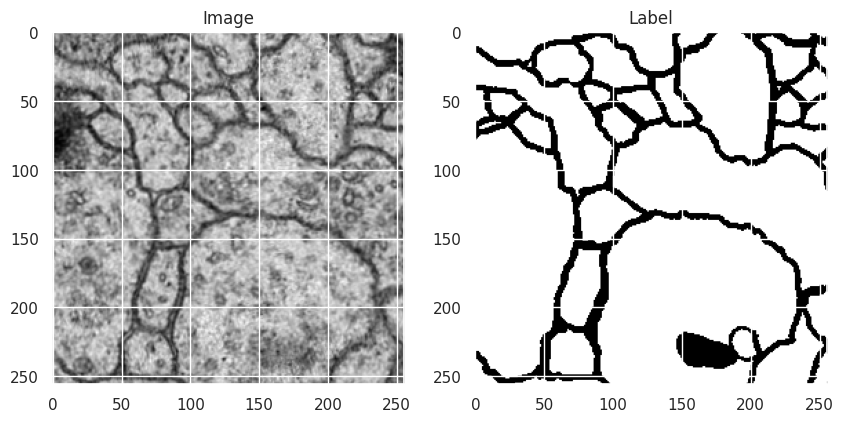

In [ ]:
img = challengeTrainData[0][0]
lbl = challengeTrainData[0][1]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Image')

ax[1].imshow(lbl, cmap='gray')
ax[1].set_title('Label')

plt.show()

# Data augmentation

In [ ]:
# Apply Random Elastic Deformation
# (This involves loading images and may take some seconds.)

def random_elastic_deformation(image, label, alpha, sigma):
    random_state = np.random.RandomState(None)
    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    img_augmented = map_coordinates(image, indices, order=1).reshape(shape)
    lbl_augmented = map_coordinates(label, indices, order=1).reshape(shape)
    return img_augmented, lbl_augmented

In [ ]:
img = challengeTrainData[0][0].numpy()
lbl = challengeTrainData[0][1].numpy()

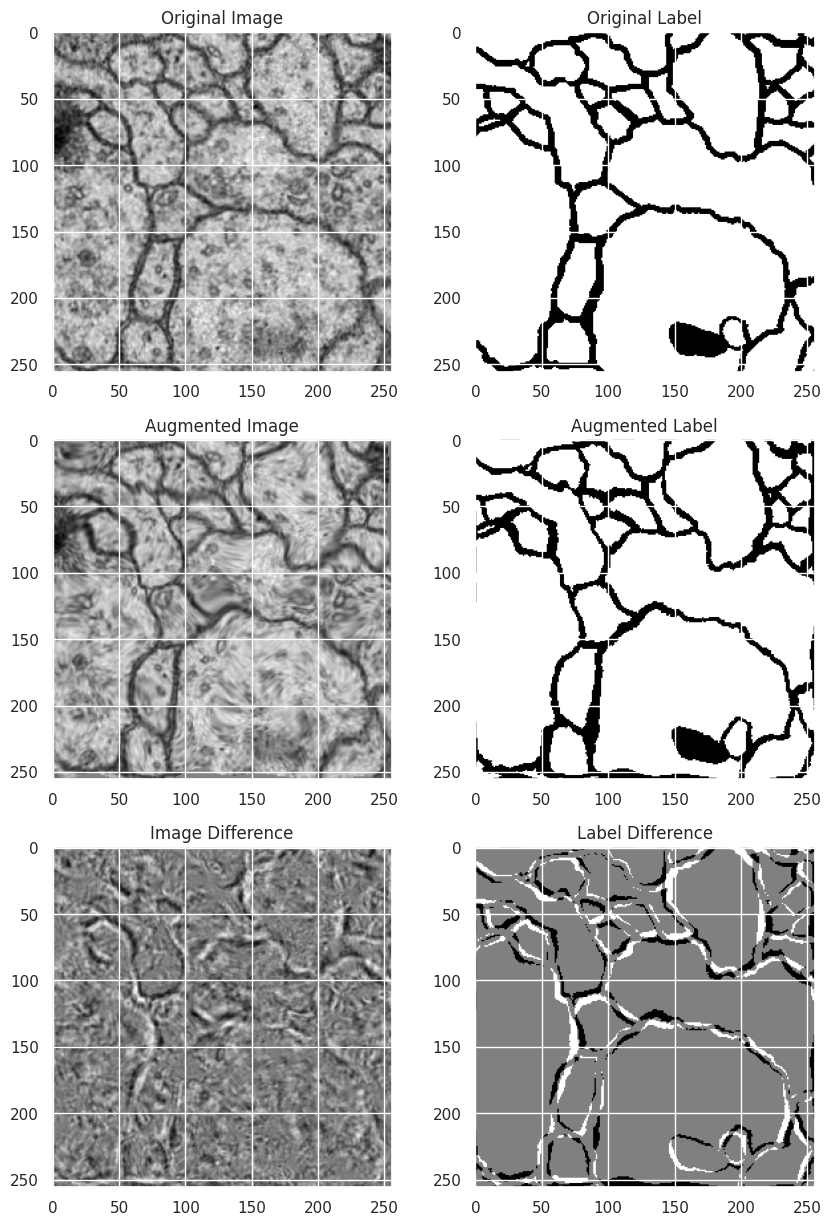

In [ ]:
img_augmented, lbl_augmented = random_elastic_deformation(img, lbl, 200, 10)
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('Original Image')

ax[0, 1].imshow(lbl, cmap='gray')
ax[0, 1].set_title('Original Label')

ax[1, 0].imshow(img_augmented, cmap='gray')
ax[1, 0].set_title('Augmented Image')

ax[1, 1].imshow(lbl_augmented, cmap='gray')
ax[1, 1].set_title('Augmented Label')

ax[2, 0].imshow(img_augmented - img, cmap='gray')
ax[2, 0].set_title('Image Difference')

ax[2, 1].imshow(lbl_augmented - lbl, cmap='gray')
ax[2, 1].set_title('Label Difference')

plt.show()

In [ ]:
# Make dataset class.
class ChallengeData(torch.utils.data.Dataset):
    '''  Dataset which loads all images for training or testing'''
    def __init__(self, data_dir, nr_im, train_set, augmentations=[], margin_size=20):
        self.images = []
        self.labels = []

        self.train_set = train_set
  
        normalizer = Normalize(mean=(0.5), std=(0.5))

        img_prefix = 'train' if train_set else 'test'
        img_folder = 'train_images' if train_set else 'test_images'
        labels_folder = 'train_labels'
        labels_prefix = 'labels'

        for idx in range(1, nr_im + 1):
            im = np.array(PIL.Image.open(f'{data_dir}/{img_folder}/{img_prefix}_{idx:02d}.png'))
            # im = im/255
            im = normalizer.apply(image=im, p=1)
            im1 = im[:256,:256]
            im2 = im[256:,:256]
            im3 = im[:256,256:]
            im4 = im[256:,256:]
            
            self.images.append(torch.tensor(im1, dtype=torch.float32))
            self.images.append(torch.tensor(im2, dtype=torch.float32))
            self.images.append(torch.tensor(im3, dtype=torch.float32))
            self.images.append(torch.tensor(im4, dtype=torch.float32))
            # Divide into iamges of size 128x128

            if train_set:
                label_im = np.array(PIL.Image.open(f'{data_dir}/{labels_folder}/{labels_prefix}_{idx:02d}.png'))
                label_im = label_im/255
                # label_im = label_im[margin_size:-margin_size, margin_size:-margin_size]/255
                label_im1 = label_im[:256,:256]
                label_im2 = label_im[256:,:256]
                label_im3 = label_im[:256,256:]
                label_im4 = label_im[256:,256:]

                self.labels.append(torch.tensor(label_im1, dtype=torch.int64))
                self.labels.append(torch.tensor(label_im2, dtype=torch.int64))
                self.labels.append(torch.tensor(label_im3, dtype=torch.int64))
                self.labels.append(torch.tensor(label_im4, dtype=torch.int64))

                for i, (small_img, small_lbl) in enumerate(zip([im1, im2, im3, im4], [label_im1, label_im2, label_im3, label_im4])):
                    for alpha in augmentations:
                        img_augmented, lbl_augmented = random_elastic_deformation(small_img, small_lbl, alpha, 10)
                        self.images.append(torch.tensor(img_augmented, dtype=torch.float32))
                        self.labels.append(torch.tensor(lbl_augmented, dtype=torch.int64))
            
    def __getitem__(self, idx):
        if self.train_set:
            return self.images[idx], self.labels[idx]
        
        return self.images[idx]
    
    def __len__(self):
        return len(self.images)

In [ ]:
# Create dataset objects.
train_data = ChallengeData(datadir, 30, True, augmentations=[20, 50, 100, 200, 500])
test_data = ChallengeData(datadir, 30, False)

# Create data loaders.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
%%time
# Train the network on the augmented data
net_augmented = Net()

# Define a loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
# criterion = dice_loss
optimizer = torch.optim.Adam(net_augmented.parameters(), lr=0.001)

epochs = 20

epoch_losses_augmented = []

for e in range(epochs):  # loop over the dataset multiple times

    losses = []

    for batch in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_augmented(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss)

    epoch_losses_augmented.append(loss.item())

    print(f'Epoch {e+1} finished. Loss: {epoch_losses_augmented[-1]}')

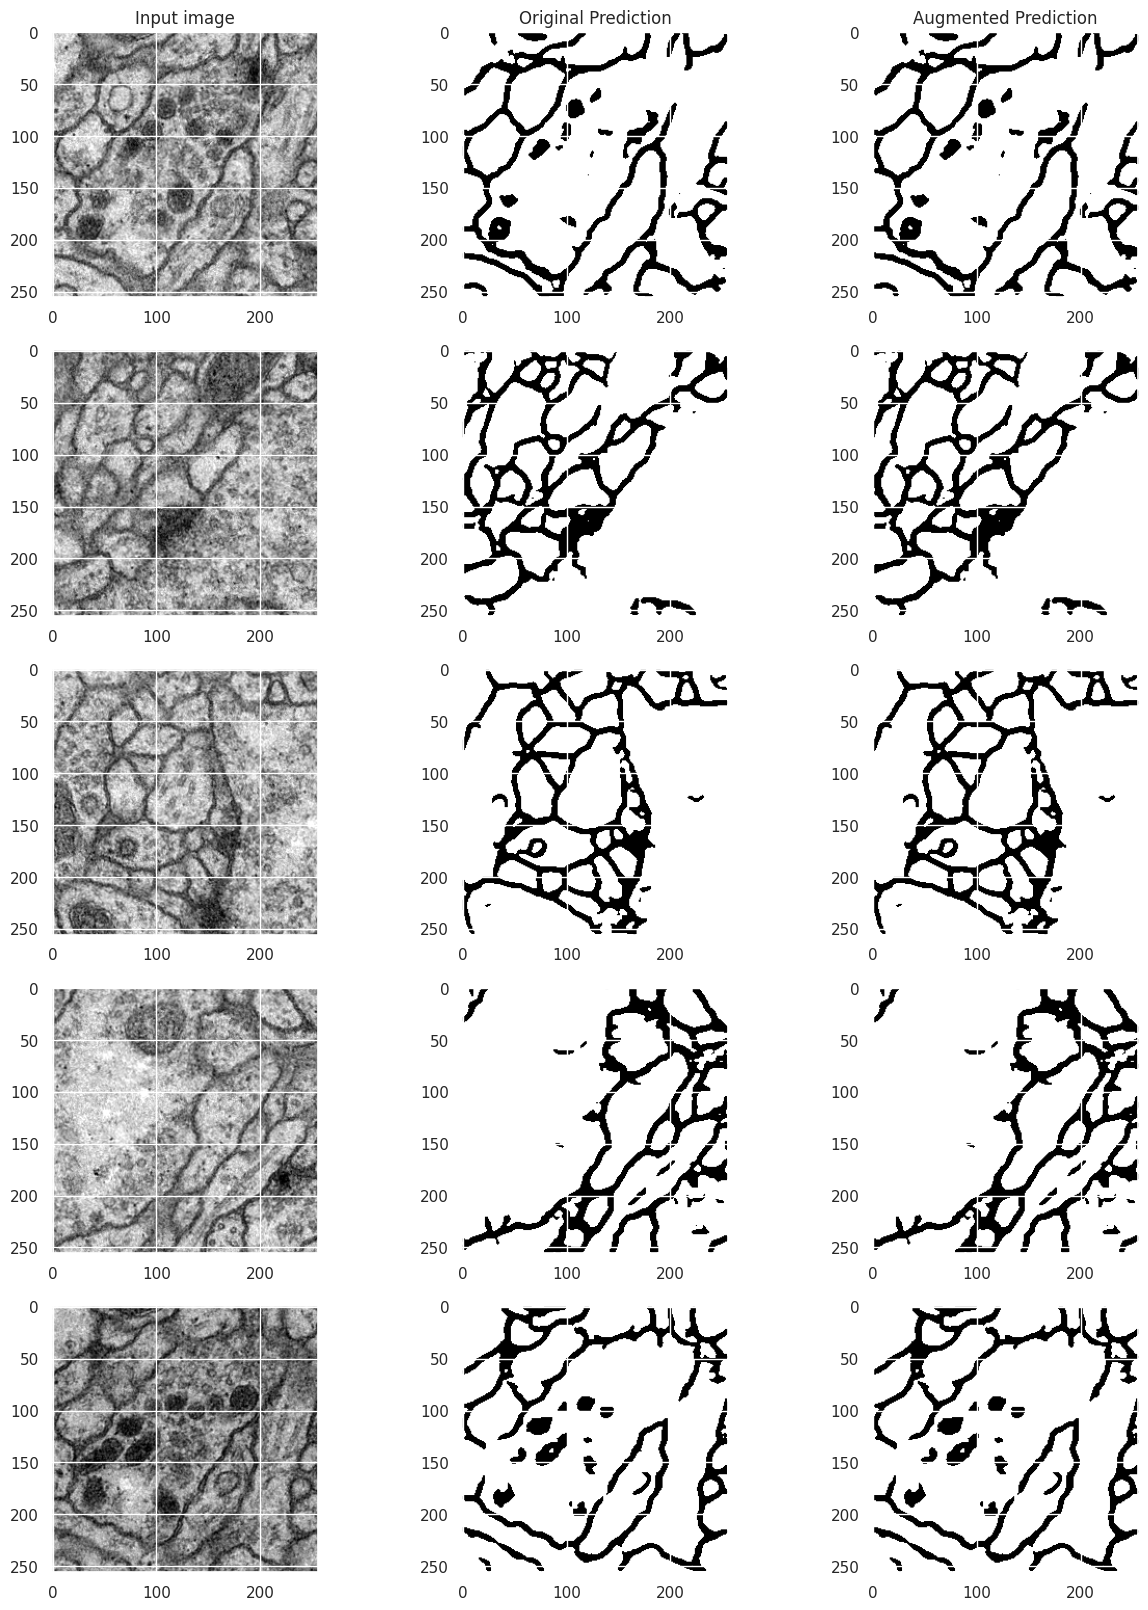

In [ ]:
# Visualize test predictions
fig, ax = plt.subplots(5, 3, figsize=(15, 20))

for i in range(5):
    ax[i, 0].imshow(challengeTestData[i], cmap='gray')
    ax[i, 1].imshow(torch.argmax(net(challengeTestData[i].unsqueeze(0).unsqueeze(0)), dim=1)[0], cmap='gray')
    ax[i, 2].imshow(torch.argmax(net_augmented(challengeTestData[i].unsqueeze(0).unsqueeze(0)), dim=1)[0], cmap='gray')

ax[0, 0].set_title('Input image')
ax[0, 1].set_title('Original Prediction')
ax[0, 2].set_title('Augmented Prediction')

plt.show()